## OCR Prediction

Paper: https://arxiv.org/abs/2001.01469

### I. Parse Data and OCR Training

For part 1, see ocr_parse_train.ipynb

### II. Predict


<b>Load Model</b>

In [ ]:
# add to tesseract langugage models 
!sudo cp dataset/ocr_full.traineddata /home/linuxbrew/.linuxbrew/share/tessdata/fintabnet_full.traineddata #REPLACE BY YOUR TESSERACT TESSDATA DIRECTORY

Source:
1. row with different colors
https://stackoverflow.com/questions/60067593/read-a-table-of-number-from-image-ocr-with-different-row-colour

In [4]:
import cv2
import pytesseract as pt
from itertools import repeat
import matplotlib.pyplot as plt
import csv
import numpy as np
from PIL import Image, ImageFilter

In [6]:
def show_images(raw, proc):
	# # Show image
	plt.figure(figsize=(12, 4))
	plt.title('Raw Image vs Processed Image')
	plt.subplot(2, 1, 1)
	plt.title('Raw')
	plt.imshow(cv2.cvtColor(raw, cv2.COLOR_BGR2RGB))
	plt.axis('off')
	plt.subplot(2, 1, 2)
	plt.title('Processed')
	plt.imshow(cv2.cvtColor(proc, cv2.COLOR_BGR2RGB))
	plt.axis('off')
	plt.tight_layout()
	plt.show()

def enhance(test_file_path):
	# # enhance rows in different color
	img = Image.open(test_file_path) 
	img_larger = img.resize((round(img.width*2),round(img.height*2))) 
	img_enhanced_more = img_larger.filter(ImageFilter.EDGE_ENHANCE_MORE)
	return img_enhanced_more

def adjust(image, sharpen=False, contrast=False):
	# image = cv2.resize(image, (int(image.shape[1] * 2), int(image.shape[0] * 2)), interpolation = cv2.INTER_AREA)
	
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

	# Repair horizontal table lines 
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
	thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

	# Remove horizontal lines
	horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (55,2))
	detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
	cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = cnts[0] if len(cnts) == 2 else cnts[1]
	# for c in cnts:
	# 	cv2.drawContours(image, [c], -1, (255,255,255), 9)

	# Remove vertical lines
	vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,55))
	detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
	cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = cnts[0] if len(cnts) == 2 else cnts[1]
	# for c in cnts:
	# 	cv2.drawContours(image, [c], -1, (255,255,255), 9)

	# sharpen
	if sharpen:
		sharpen_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
		image = cv2.filter2D(image, -1, sharpen_filter)
	if contrast:
		image = cv2.convertScaleAbs(image, alpha=1.5, beta=0)
	return image

<b>remove background</b>

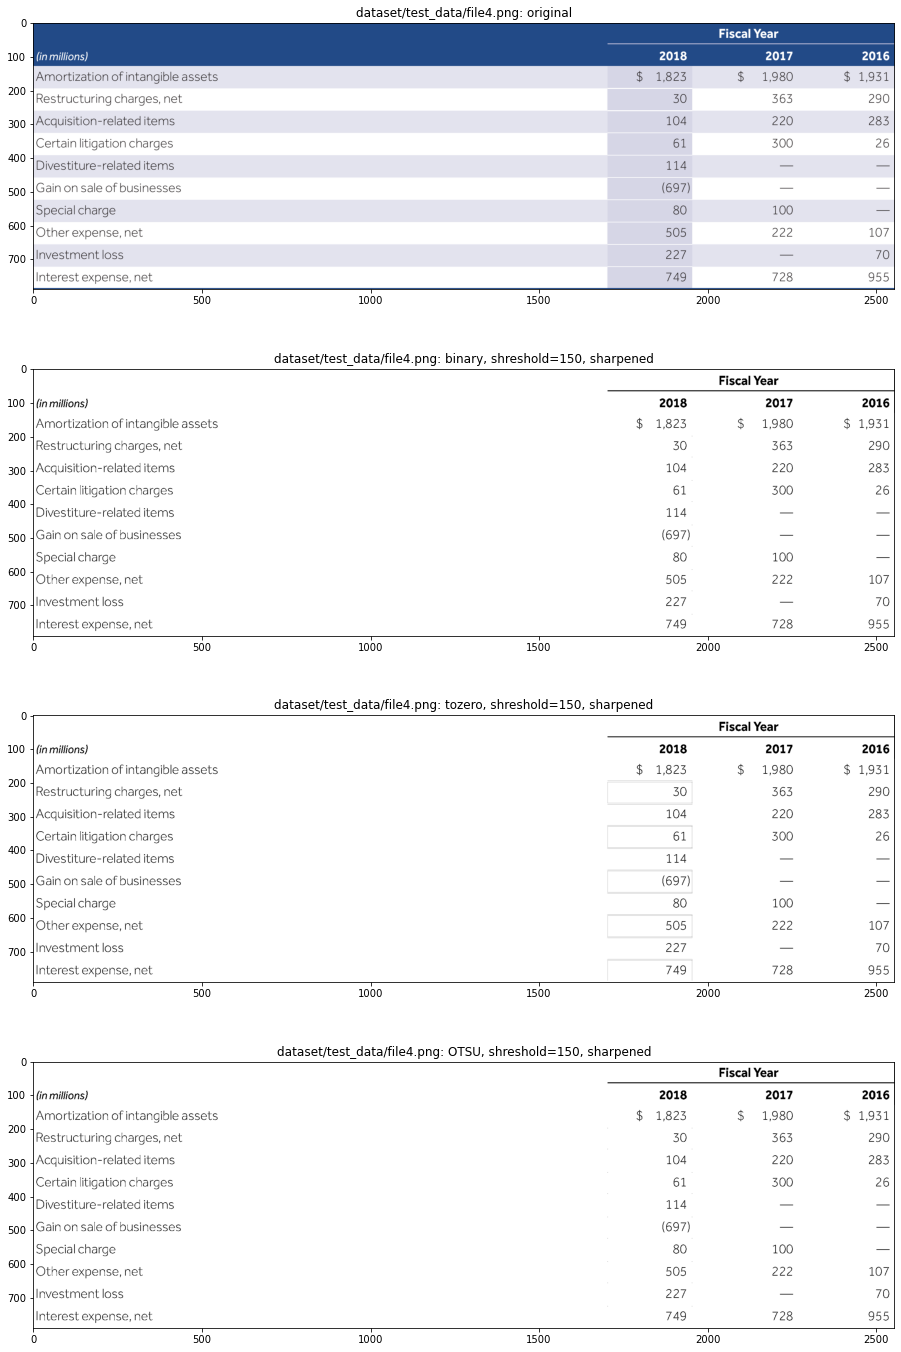

In [28]:

from script.ocr_preprocess import remove_background
img_name = "dataset/test_data/file4.png"
img = cv2.imread(img_name)

plots_=dict()
plots_['original'] = img

# try different methods
for s in [True]: #[False, True]
    for m in ['binary','tozero','OTSU']: #'adaptive'
        for th in [150]: #[120, 125, 130]
            tozero_thresh = [100,200] if m == 'tozero' else None
            title, im = remove_background(img, method=m, thresh=th, sharpen=s,tozero_thresh = tozero_thresh)
            plots_.update({title:im})
# plot
fig, axes = plt.subplots(len(plots_), 1, sharex=False, #True,
                         gridspec_kw=(dict(hspace=0.3,wspace=0.1)), figsize=(24,6*len(plots_))
                         )
d_ = list(plots_.items())
for i in range(len(plots_)):
    axes[i].imshow(cv2.cvtColor(d_[i][1], cv2.COLOR_BGR2RGB))
    axes[i].set_title(img_name+': '+d_[i][0])

plt.show()

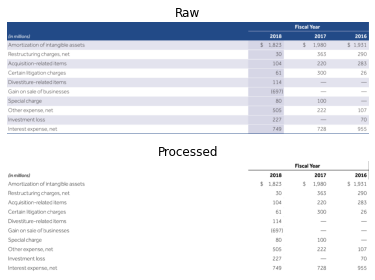

Fiscal Year
(in millions) 2018 2017 2016
Amortization of intangible assets $1,823 $1,980 $1,931
Restructuring charges, net 30 363 290
Acquisition-related items 104 220 283
Certain litigation charges 61 300 26
Divestiture-related items 114 — —
Gain on sale of businesses (697) — —
Special charge 80 100 —
Other expense, net 505 222 107
Investment loss 227 — 70
Interest expense, net 749 728 955



In [33]:
def extract(test_file_path, output_csv_path, output_text_path):

	image = cv2.imread(test_file_path)
	raw = image.copy()
	
	# adjust image
	image = adjust(image)
	_, image = remove_background(image, method="binary", thresh=150, sharpen=True, tozero_thresh = [100,200])

	# show preview
	show_images(raw, image)

	# OCR 
	# config options: https://stackoverflow.com/questions/44619077/pytesseract-ocr-multiple-config-options
	data = pt.image_to_string(image, lang='fintabnet_full', config='--psm 6') 
	print(data)

	# write data to txt
	with open(output_text_path, "w+") as f:
		f.write(data)

		# write structured table to csv **UNTESTED**
		# with open(output_text_path, 'r') as in_file:
		# 	stripped = (line.strip() for line in in_file)
		# 	lines = (line.split("|") for line in stripped if line)
		# 	with open(output_csv_path, 'w') as out_file:
		# 		writer = csv.writer(out_file)
		# 		writer.writerow((' ', ' '))
		# 		writer.writerows(lines)

	return data

# from script.text_extract import extract
data = extract("dataset/test_data/file4.png", "dataset/test_data/sample_text_psm_6.csv", "dataset/test_data/sample_text_psm_6.txt")

### III. Evaluation

#### CER: character-level

+ $CER = (S+D+I)/N$
    + where:
    + S = Number of Substitutions
    + D = Number of Deletions
    + I = Number of Insertions
    + N = Number of characters in reference text (aka ground truth)

- evaluation:

    + Good OCR accuracy: CER 1‐2% (i.e. 98–99% accurate)
    + Average OCR accuracy: CER 2-10%
    + Poor OCR accuracy: CER >10% (i.e. below 90% accurate)

#### WER: word-level

- $WER = (S_w+D_w+I_w)/N_w$
    + A WER of 5-10% is considered to be good quality and is ready to use.

In [35]:
# !pip install pybind11
# !pip install fastwer
import fastwer

In [36]:
# strip ground truth
with open("dataset/test_data/gt.txt", 'r') as in_file:
    ref = " ".join([line.strip() for line in in_file])
print("ground truth:\n", ref)

# strip output
with open("dataset/test_data/sample_text_psm_6.txt", 'r') as in_file:
    output = " ".join(" ".join(data.split()).split("\n"))
print("\nocr output:\n", output)


ground truth:
 Fiscal Year (in millions) 2018 2017 2016 Amortization of intangible assets $1,823 $1,980 $1,931 Restructuring charges, net 30 363 290 Acquisition-related items 104 220 283 Certain litigation charges 61 300 26 Divestiture-related items 114 — — Gain on sale of businesses (697) — — Special charge 80 100 — Other expense, net 505 222 107 Investment loss 227 — 70 Interest expense, net 749 728 955

ocr output:
 Fiscal Year (in millions) 2018 2017 2016 Amortization of intangible assets $1,823 $1,980 $1,931 Restructuring charges, net 30 363 290 Acquisition-related items 104 220 283 Certain litigation charges 61 300 26 Divestiture-related items 114 — — Gain on sale of businesses (697) — — Special charge 80 100 — Other expense, net 505 222 107 Investment loss 227 — 70 Interest expense, net 749 728 955


#### Result

<b> psm 6 </b>

In [15]:
# Obtain Sentence-Level Character/Word Error Rate (CER/WER) for psm=6
print("CER:", fastwer.score_sent(output, ref, char_level=True))
print("WER:", fastwer.score_sent(output, ref, char_level=False))

CER: 2.963
WER: 3.0303


<b> psm 6, full-size model + background removal </b>

In [37]:
# Obtain Sentence-Level Character/Word Error Rate (CER/WER) for psm=6
print("CER:", fastwer.score_sent(output, ref, char_level=True))
print("WER:", fastwer.score_sent(output, ref, char_level=False))

CER: 0.0
WER: 0.0


<b> psm 12 </b>

In [238]:
# Obtain Sentence-Level Character/Word Error Rate (CER/WER) for psm=12
print("CER:", fastwer.score_sent(output, ref, char_level=True))
print("WER:", fastwer.score_sent(output, ref, char_level=False))

CER: 7.1605
WER: 15.1515


### IV. Misc
<b> OCR via shell</b>


In [ ]:
filename = "file4"
cv2.imwrite(f"dataset/test_data/{filename}_proc.tiff", image)

!tesseract -l fintabnet -c preserve_interword_spaces=1 dataset/test_data/file4_proc.tiff output --psm 6 --oem 1

<b>single cell mode recognizition</b>

In [ ]:
test_file_path, output_csv_path, output_text_path = "dataset/test_data/file4.png", "dataset/test_data/sample_text_psm_6.csv", "dataset/test_data/sample_text_psm_6.txt"
result = ""

# for i in range(1):
for i in range(44):
	test_file_path = f"dataset/Fintabnet_data/ocr_traindata/cell/file4_seg_{i}.png"
	# test_file_path = f"dataset/test_data/single_line.png"
	image = cv2.imread(test_file_path)
	raw = image.copy()

	# adjust image
	image = adjust(image)

	# show preview
	show_images(raw, image)

	# OCR 
	# data = pt.image_to_string(image, lang='fintabnet', config='--psm 7') 
	data = pt.image_to_string(image, lang='fintabnet_full', config='--psm 7') 
	# data = pt.image_to_string(image, lang='fintabnet', config='--psm 12') 
	# psm 6 works best for structure, psm 12 works best for single-word recognization
	# config options: https://stackoverflow.com/questions/44619077/pytesseract-ocr-multiple-config-options
	
	# with open(f"dataset/Fintabnet_data/cell_mask/ocr_traindata/file4_seg_{i}.gt.txt", 'r') as in_file:
	# 	ref = " ".join([line.strip() for line in in_file])
	# print(data.strip("\n"), "\t", ref) 
	print(data.strip("\n"))

	result = result + (data + "\t")

	# write data to txt
	with open(output_text_path, "w+") as f:
		f.write(data + "\t")


<!-- 
Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
                        bypassing hacks that are Tesseract-specific. -->